#Requirements

In [0]:
!pip install librosa -U --quiet
!pip install torchaudio --quiet

     |████████████████████████████████| 1.6MB 3.9MB/s 
     |████████████████████████████████| 3.1MB 4.8MB/s 


#Imports

In [0]:
import warnings
warnings.simplefilter('ignore')

In [0]:
import os
import sys
import cv2
import glob
import math
import random
import librosa
import zipfile
import numpy as np
import pandas as pd
from librosa import display as libdisplay
from tqdm.notebook import tqdm

In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from torchvision import models
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
import IPython.display as ipd
from matplotlib import pyplot as plt

#Envs

In [0]:
path = '../Data/'

In [0]:
seed = 2020

In [0]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [0]:
#will store our models here
os.makedirs('MODELS/', exist_ok=True)

In [0]:
#Placeholder for the training and test spectogram's images
#It is going to store the spec, we will shortly generate.
os.makedirs('Imgs/Train/', exist_ok=True)
os.makedirs('Imgs/Test/', exist_ok=True)

#Unzip

In [0]:
!unzip -q {path}Train.zip
!unzip -q {path}Test.zip

#Utilities

In [0]:
def show_audio(ad):
    sig,sr = ad
    ipd.display(ipd.Audio(data=sig, rate=sr))

In [0]:
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    https://www.kaggle.com/wiki/MultiClassLogLoss

    idea from this post:
    http://www.kaggle.com/c/emc-data-science/forums/t/2149/is-anyone-noticing-difference-betwen-validation-and-leaderboard-error/12209#post12209

    Parameters
    ----------
    y_true : array, shape = [n_samples]
    y_pred : array, shape = [n_samples, n_classes]

    Returns
    -------
    loss : float
    """
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    return -1.0 / rows * vsota

In [0]:
def melspectogram_dB(file_path, cst=5, top_db=80.):
  row_sound, sr = librosa.load(file_path)
  sound = np.zeros((cst*sr,))

  if row_sound.shape[0] < cst*sr:
    sound[:row_sound.shape[0]] = row_sound[:]
  else:
    sound[:] = row_sound[:cst*sr]

  spec = librosa.feature.melspectrogram(sound, sr)
  spec_db = librosa.power_to_db(spec, top_db=top_db)

  return spec_db

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_img = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  
  return spec_img.astype(np.uint8)

def save_spec_image(spec_img, fname):
  cv2.imwrite(fname, spec_img)

In [0]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, df, task='train', size=(300, 230), **kwargs):
    super(AudioDataset, self).__init__()
    self.df = df
    self.task = task
    self.size = size
    self.c = len(birds)
    self.classes = birds

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fn = self.df.loc[idx, 'spec_name']

    spec = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    spec = cv2.resize(spec, self.size)

    output = {
        'spec': torch.tensor(spec, dtype=torch.float).unsqueeze(0),
    }

    if self.task=='train':
      label = self.df.loc[idx, 'label']
      output.update({'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float ) })

    return output

In [0]:
class AudioModel(torch.nn.Module):
  def __init__(self, arch_name='resnet34', pretrained=True, fc_size=512, out_size=40, **kwargs):
    super(AudioModel, self).__init__()

    self.arch = getattr(models, arch_name)(pretrained)

    head = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
    head.weight = torch.nn.Parameter(self.arch.conv1.weight.sum(dim=1, keepdim=True))

    self.arch.conv1 = head
    self.arch.fc = torch.nn.Linear(fc_size, out_size)
    torch.nn.init.xavier_normal_(self.arch.fc.weight)

  def forward(self, x):
    x = self.arch(x)
    x = F.sigmoid(x)

    return x

In [0]:
def training_fn(dataloader, model, opt, criterion, epoch):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0

  model.train()

  for i, data in enumerate(dataloader):
    x,y = data['spec'].to(device), data['label'].to(device)

    opt.zero_grad()

    pred = model(x)
    loss = criterion(pred, y)

    avg_loss += loss
    avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
    avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())

    loss.backward()
    opt.step()

  avg_loss_nump = avg_loss.cpu().detach().numpy()
  avg_acc_nump = avg_acc.cpu().detach().numpy()
  print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader),
                                                                        avg_logloss/len(dataloader)))
  

In [0]:
def evaluate(dataloader, model, criterion):
  avg_loss = 0
  avg_acc = 0
  avg_logloss = 0
  model.eval()

  with torch.no_grad():
    for data in dataloader:
      x = data['spec'].to(device)
      y = data['label'].to(device)

      pred = model(x)
      
      avg_loss += criterion(pred, y)
      avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()
      avg_logloss += multiclass_log_loss(y.cpu().detach().numpy().argmax(1), pred.cpu().detach().numpy())
    
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)
    avg_logloss /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f} - LogLoss {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy(), avg_logloss))
    
  return avg_logloss

In [0]:
def predict(df, size, bs=2):
  test_ds = AudioDataset(df, task='test', size=size)
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    x = data['spec'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](x)
      else: out += MODELS[i](x)

    out /= n_folds
    out_labels = out.argmax(1).cpu().detach().numpy()
    out_probas = out.cpu().detach().numpy()

    predictions_labels += out_labels.tolist()
    predictions_proba += out_probas.tolist()

  return predictions_labels ,predictions_proba

In [0]:
def run_fold(fold, bs=16, eval_bs=8, lr=1e-4, size=(500, 230), arch='resnet34', layer='fc', fc_size=512,  path='MODELS/'):
  best_logloss = np.inf

  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)

  train_ds = AudioDataset(fold_train, size=size)
  val_ds = AudioDataset(fold_val, size=size)

  trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
  validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  model = AudioModel(arch, fc_size=fc_size, layer=layer)
  criterion = torch.nn.BCELoss()
  opt = torch.optim.AdamW(model.parameters(), lr=lr)
  
  model.to(device)

  loader = tqdm(range(epochs), desc='Training')

  for epoch in loader:
    training_fn(trainloader, model, opt, criterion, epoch)
    avg_logloss = evaluate(validloader, model, criterion)

    if avg_logloss < best_logloss:
      best_logloss = avg_logloss
      torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

  return best_logloss

#Loading the CSVs' files

In [0]:
train = pd.read_csv(path+'Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [0]:
sub = pd.read_csv(path+'SampleSubmission.csv')
sub.head(1)

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [0]:
# Add file names
train['file_name'] = 'Train/'+train['ID']+'.mp3'
sub['file_name'] = 'Test/'+sub['ID']+'.mp3'

In [0]:
# Add file names
train['spec_name'] = 'Imgs/Train/'+train['ID']+'.png'
sub['spec_name'] = 'Imgs/Test/'+sub['ID']+'.png'

In [0]:
label = np.linspace(0, len(birds)-1, len(birds), dtype=np.int16)
mapper = dict(zip(birds, label))

In [0]:
train['label'] = train['common_name'].map(mapper).astype(int)

In [0]:
train.head()

,ID,common_name,file_name,spec_name,label
0,MBMG2C,Ring-necked Dove,Train/MBMG2C.mp3,Imgs/Train/MBMG2C.png,0
1,K8LJSB,Ring-necked Dove,Train/K8LJSB.mp3,Imgs/Train/K8LJSB.png,0
2,OGD9L6,Ring-necked Dove,Train/OGD9L6.mp3,Imgs/Train/OGD9L6.png,0
3,581PCQ,Ring-necked Dove,Train/581PCQ.mp3,Imgs/Train/581PCQ.png,0
4,P91M1F,Ring-necked Dove,Train/P91M1F.mp3,Imgs/Train/P91M1F.png,0


#Generate Specs

In [0]:
# This takes a lot of time to complete. So, you may want to save the spectogram images once generated.
# See the next section to save it

In [0]:
#Training specs
for row in tqdm(train.values):
  sound_path = row[2] #this corresponds to 'file_name'
  spec_name = row[3] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 15)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

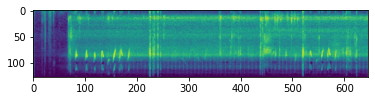

In [0]:
plt.imshow(spec)

In [0]:
#Test specs
for row in tqdm(sub.values):
  sound_path = row[-2] #this corresponds to 'file_name'
  spec_name = row[-1] #this corresponds to 'spec_name'

  spec = melspectogram_dB(sound_path, 15)
  spec = spec_to_image(spec)
  save_spec_image(spec, spec_name)

#Save the Specs

In [0]:
#This code zips the generated spec images
!zip -r Spec_imgs_cst_15.zip Imgs

In [0]:
train.to_csv('final_train.csv',index=False)
sub.to_csv('final_test.csv',index=False)

#Training

In [0]:
n_folds = 10

In [0]:
train['fold'] = 0

fold = StratifiedKFold(n_splits = n_folds, random_state=seed)
for i, (tr, vr) in enumerate(fold.split(train, train['label'])):
  train.loc[vr, 'fold'] = i

In [0]:
epochs = 15
device = 'cuda'
size = (500, 200)
arch='resnet34'
fc_size = 512
bs = 8
lr = 1e-4

In [0]:
avg_logloss = 0
best_fold = 0
fold_logloss = np.inf

for fold in range(n_folds):
  _fold_logloss = run_fold(fold, size=size, arch=arch, fc_size=fc_size, lr=lr, bs=bs)
  avg_logloss += _fold_logloss

  if fold_logloss > _fold_logloss: best_fold = fold

print()
print("Avg LogLoss: ", avg_logloss/n_folds)

[Training] Epoch 0 : Loss: 0.13772 - Acc : 0.16946 - LogLoss 3.21259
[Evaluation] Loss: 0.07516 - Acc : 0.44271 - LogLoss 2.06462
[Training] Epoch 1 : Loss: 0.06920 - Acc : 0.49143 - LogLoss 1.95900
[Evaluation] Loss: 0.05889 - Acc : 0.67188 - LogLoss 1.38710
[Training] Epoch 2 : Loss: 0.04961 - Acc : 0.67404 - LogLoss 1.34021
[Evaluation] Loss: 0.04901 - Acc : 0.72917 - LogLoss 1.13908
[Training] Epoch 3 : Loss: 0.03539 - Acc : 0.79605 - LogLoss 0.90840
[Evaluation] Loss: 0.04354 - Acc : 0.80729 - LogLoss 0.91027
[Training] Epoch 4 : Loss: 0.02423 - Acc : 0.87779 - LogLoss 0.59311
[Evaluation] Loss: 0.05217 - Acc : 0.72917 - LogLoss 0.98673
[Training] Epoch 5 : Loss: 0.01762 - Acc : 0.92464 - LogLoss 0.42885
[Evaluation] Loss: 0.03645 - Acc : 0.81250 - LogLoss 0.70298
[Training] Epoch 6 : Loss: 0.01116 - Acc : 0.96232 - LogLoss 0.25979
[Evaluation] Loss: 0.04500 - Acc : 0.80208 - LogLoss 0.89957
[Training] Epoch 7 : Loss: 0.01060 - Acc : 0.96292 - LogLoss 0.24958
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.14120 - Acc : 0.19637 - LogLoss 3.10155
[Evaluation] Loss: 0.07448 - Acc : 0.51042 - LogLoss 1.94521
[Training] Epoch 1 : Loss: 0.06671 - Acc : 0.52293 - LogLoss 1.88079
[Evaluation] Loss: 0.05887 - Acc : 0.55208 - LogLoss 1.52584
[Training] Epoch 2 : Loss: 0.04861 - Acc : 0.68939 - LogLoss 1.29152
[Evaluation] Loss: 0.05630 - Acc : 0.68750 - LogLoss 1.21704
[Training] Epoch 3 : Loss: 0.03339 - Acc : 0.80243 - LogLoss 0.85353
[Evaluation] Loss: 0.04364 - Acc : 0.77604 - LogLoss 1.01339
[Training] Epoch 4 : Loss: 0.02367 - Acc : 0.88636 - LogLoss 0.59075
[Evaluation] Loss: 0.05442 - Acc : 0.74479 - LogLoss 1.14017
[Training] Epoch 5 : Loss: 0.01538 - Acc : 0.94119 - LogLoss 0.36682
[Evaluation] Loss: 0.05924 - Acc : 0.73958 - LogLoss 1.19988
[Training] Epoch 6 : Loss: 0.01239 - Acc : 0.95036 - LogLoss 0.29132
[Evaluation] Loss: 0.03710 - Acc : 0.79167 - LogLoss 0.78912
[Training] Epoch 7 : Loss: 0.00994 - Acc : 0.96411 - LogLoss 0.21955
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.13170 - Acc : 0.28050 - LogLoss 2.89439
[Evaluation] Loss: 0.06832 - Acc : 0.53125 - LogLoss 1.74071
[Training] Epoch 1 : Loss: 0.06143 - Acc : 0.58752 - LogLoss 1.71271
[Evaluation] Loss: 0.05106 - Acc : 0.65104 - LogLoss 1.27001
[Training] Epoch 2 : Loss: 0.04370 - Acc : 0.72169 - LogLoss 1.15986
[Evaluation] Loss: 0.05203 - Acc : 0.68750 - LogLoss 1.24450
[Training] Epoch 3 : Loss: 0.02971 - Acc : 0.84151 - LogLoss 0.74852
[Evaluation] Loss: 0.04552 - Acc : 0.77083 - LogLoss 0.90174
[Training] Epoch 4 : Loss: 0.02059 - Acc : 0.89533 - LogLoss 0.50619
[Evaluation] Loss: 0.05183 - Acc : 0.71875 - LogLoss 1.13942
[Training] Epoch 5 : Loss: 0.01395 - Acc : 0.94418 - LogLoss 0.32738
[Evaluation] Loss: 0.05394 - Acc : 0.73958 - LogLoss 0.95229
[Training] Epoch 6 : Loss: 0.01123 - Acc : 0.95933 - LogLoss 0.26255
[Evaluation] Loss: 0.04267 - Acc : 0.80729 - LogLoss 0.88441
[Training] Epoch 7 : Loss: 0.00931 - Acc : 0.96591 - LogLoss 0.21197
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.14849 - Acc : 0.21292 - LogLoss 3.05590
[Evaluation] Loss: 0.07458 - Acc : 0.46354 - LogLoss 2.01454
[Training] Epoch 1 : Loss: 0.06748 - Acc : 0.52492 - LogLoss 1.90729
[Evaluation] Loss: 0.05993 - Acc : 0.58854 - LogLoss 1.52450
[Training] Epoch 2 : Loss: 0.04794 - Acc : 0.69418 - LogLoss 1.29804
[Evaluation] Loss: 0.04869 - Acc : 0.75000 - LogLoss 1.13045
[Training] Epoch 3 : Loss: 0.03398 - Acc : 0.80144 - LogLoss 0.87985
[Evaluation] Loss: 0.05124 - Acc : 0.75000 - LogLoss 0.94278
[Training] Epoch 4 : Loss: 0.02352 - Acc : 0.88198 - LogLoss 0.58768
[Evaluation] Loss: 0.04337 - Acc : 0.76562 - LogLoss 0.90581
[Training] Epoch 5 : Loss: 0.01596 - Acc : 0.93780 - LogLoss 0.38744
[Evaluation] Loss: 0.04356 - Acc : 0.78646 - LogLoss 0.86144
[Training] Epoch 6 : Loss: 0.01193 - Acc : 0.95395 - LogLoss 0.28033
[Evaluation] Loss: 0.04611 - Acc : 0.75000 - LogLoss 0.88972
[Training] Epoch 7 : Loss: 0.00866 - Acc : 0.97428 - LogLoss 0.20449
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.13550 - Acc : 0.24841 - LogLoss 2.92747
[Evaluation] Loss: 0.07683 - Acc : 0.42708 - LogLoss 2.06494
[Training] Epoch 1 : Loss: 0.06447 - Acc : 0.55602 - LogLoss 1.80934
[Evaluation] Loss: 0.06288 - Acc : 0.62500 - LogLoss 1.41173
[Training] Epoch 2 : Loss: 0.04569 - Acc : 0.69896 - LogLoss 1.21895
[Evaluation] Loss: 0.05615 - Acc : 0.66667 - LogLoss 1.30486
[Training] Epoch 3 : Loss: 0.03160 - Acc : 0.82835 - LogLoss 0.80221
[Evaluation] Loss: 0.06219 - Acc : 0.72917 - LogLoss 1.28353
[Training] Epoch 4 : Loss: 0.02028 - Acc : 0.91268 - LogLoss 0.49347
[Evaluation] Loss: 0.04686 - Acc : 0.77604 - LogLoss 1.02435
[Training] Epoch 5 : Loss: 0.01383 - Acc : 0.95275 - LogLoss 0.33252
[Evaluation] Loss: 0.04489 - Acc : 0.75000 - LogLoss 0.99567
[Training] Epoch 6 : Loss: 0.01188 - Acc : 0.95395 - LogLoss 0.27588
[Evaluation] Loss: 0.04354 - Acc : 0.76562 - LogLoss 1.01315
[Training] Epoch 7 : Loss: 0.01037 - Acc : 0.96172 - LogLoss 0.24000
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.14736 - Acc : 0.24522 - LogLoss 2.99266
[Evaluation] Loss: 0.06977 - Acc : 0.52604 - LogLoss 1.92011
[Training] Epoch 1 : Loss: 0.06392 - Acc : 0.55782 - LogLoss 1.78993
[Evaluation] Loss: 0.06752 - Acc : 0.63021 - LogLoss 1.57684
[Training] Epoch 2 : Loss: 0.04503 - Acc : 0.71730 - LogLoss 1.20052
[Evaluation] Loss: 0.06171 - Acc : 0.63021 - LogLoss 1.36695
[Training] Epoch 3 : Loss: 0.03106 - Acc : 0.83074 - LogLoss 0.78621
[Evaluation] Loss: 0.05181 - Acc : 0.70312 - LogLoss 1.16522
[Training] Epoch 4 : Loss: 0.02097 - Acc : 0.90072 - LogLoss 0.51389
[Evaluation] Loss: 0.04911 - Acc : 0.70833 - LogLoss 0.99971
[Training] Epoch 5 : Loss: 0.01448 - Acc : 0.94438 - LogLoss 0.34465
[Evaluation] Loss: 0.06112 - Acc : 0.72396 - LogLoss 1.09621
[Training] Epoch 6 : Loss: 0.01091 - Acc : 0.96471 - LogLoss 0.24968
[Evaluation] Loss: 0.04587 - Acc : 0.77083 - LogLoss 0.97348
[Training] Epoch 7 : Loss: 0.00883 - Acc : 0.97169 - LogLoss 0.19735
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.14103 - Acc : 0.22608 - LogLoss 3.01897
[Evaluation] Loss: 0.07388 - Acc : 0.50000 - LogLoss 1.99942
[Training] Epoch 1 : Loss: 0.06282 - Acc : 0.56619 - LogLoss 1.74813
[Evaluation] Loss: 0.05583 - Acc : 0.67188 - LogLoss 1.44303
[Training] Epoch 2 : Loss: 0.04490 - Acc : 0.72448 - LogLoss 1.19413
[Evaluation] Loss: 0.05942 - Acc : 0.61979 - LogLoss 1.36671
[Training] Epoch 3 : Loss: 0.03093 - Acc : 0.83234 - LogLoss 0.78786
[Evaluation] Loss: 0.05559 - Acc : 0.71875 - LogLoss 1.24128
[Training] Epoch 4 : Loss: 0.01989 - Acc : 0.90730 - LogLoss 0.48663
[Evaluation] Loss: 0.04429 - Acc : 0.75521 - LogLoss 0.97908
[Training] Epoch 5 : Loss: 0.01570 - Acc : 0.93880 - LogLoss 0.37532
[Evaluation] Loss: 0.05863 - Acc : 0.71875 - LogLoss 1.22583
[Training] Epoch 6 : Loss: 0.01200 - Acc : 0.95435 - LogLoss 0.27977
[Evaluation] Loss: 0.04275 - Acc : 0.77083 - LogLoss 0.96608
[Training] Epoch 7 : Loss: 0.00993 - Acc : 0.96531 - LogLoss 0.23083
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.12843 - Acc : 0.22667 - LogLoss 2.99997
[Evaluation] Loss: 0.07761 - Acc : 0.41146 - LogLoss 2.19920
[Training] Epoch 1 : Loss: 0.06437 - Acc : 0.54426 - LogLoss 1.79313
[Evaluation] Loss: 0.06352 - Acc : 0.58333 - LogLoss 1.62652
[Training] Epoch 2 : Loss: 0.04603 - Acc : 0.72069 - LogLoss 1.22901
[Evaluation] Loss: 0.05882 - Acc : 0.64062 - LogLoss 1.35848
[Training] Epoch 3 : Loss: 0.03160 - Acc : 0.82297 - LogLoss 0.80950
[Evaluation] Loss: 0.05398 - Acc : 0.70312 - LogLoss 1.28578
[Training] Epoch 4 : Loss: 0.02139 - Acc : 0.89414 - LogLoss 0.52906
[Evaluation] Loss: 0.06049 - Acc : 0.68229 - LogLoss 1.27780
[Training] Epoch 5 : Loss: 0.01272 - Acc : 0.95754 - LogLoss 0.30115
[Evaluation] Loss: 0.05978 - Acc : 0.73958 - LogLoss 1.19801
[Training] Epoch 6 : Loss: 0.01145 - Acc : 0.95574 - LogLoss 0.26179
[Evaluation] Loss: 0.05642 - Acc : 0.70312 - LogLoss 1.09901
[Training] Epoch 7 : Loss: 0.01057 - Acc : 0.95574 - LogLoss 0.24348
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.13089 - Acc : 0.27213 - LogLoss 2.91764
[Evaluation] Loss: 0.07864 - Acc : 0.41146 - LogLoss 2.18349
[Training] Epoch 1 : Loss: 0.06154 - Acc : 0.56519 - LogLoss 1.71643
[Evaluation] Loss: 0.06082 - Acc : 0.60938 - LogLoss 1.61757
[Training] Epoch 2 : Loss: 0.04274 - Acc : 0.73565 - LogLoss 1.13052
[Evaluation] Loss: 0.06730 - Acc : 0.61979 - LogLoss 1.48666
[Training] Epoch 3 : Loss: 0.02973 - Acc : 0.84031 - LogLoss 0.76086
[Evaluation] Loss: 0.06134 - Acc : 0.60417 - LogLoss 1.54180
[Training] Epoch 4 : Loss: 0.01995 - Acc : 0.90969 - LogLoss 0.49719
[Evaluation] Loss: 0.05335 - Acc : 0.69792 - LogLoss 1.28938
[Training] Epoch 5 : Loss: 0.01406 - Acc : 0.94318 - LogLoss 0.33196
[Evaluation] Loss: 0.06369 - Acc : 0.66667 - LogLoss 1.50036
[Training] Epoch 6 : Loss: 0.01233 - Acc : 0.95275 - LogLoss 0.29159
[Evaluation] Loss: 0.06329 - Acc : 0.65625 - LogLoss 1.40223
[Training] Epoch 7 : Loss: 0.00929 - Acc : 0.96890 - LogLoss 0.21379
[Evaluation] Loss: 0.

[Training] Epoch 0 : Loss: 0.15593 - Acc : 0.20813 - LogLoss 3.10854
[Evaluation] Loss: 0.09270 - Acc : 0.28125 - LogLoss 2.68695
[Training] Epoch 1 : Loss: 0.06620 - Acc : 0.54127 - LogLoss 1.85511
[Evaluation] Loss: 0.08136 - Acc : 0.40104 - LogLoss 2.32548
[Training] Epoch 2 : Loss: 0.04571 - Acc : 0.71471 - LogLoss 1.22658
[Evaluation] Loss: 0.08241 - Acc : 0.47917 - LogLoss 2.12668
[Training] Epoch 3 : Loss: 0.03090 - Acc : 0.83553 - LogLoss 0.79332
[Evaluation] Loss: 0.08238 - Acc : 0.47396 - LogLoss 2.10670
[Training] Epoch 4 : Loss: 0.02175 - Acc : 0.88457 - LogLoss 0.54169
[Evaluation] Loss: 0.07978 - Acc : 0.52604 - LogLoss 2.06524
[Training] Epoch 5 : Loss: 0.01545 - Acc : 0.93600 - LogLoss 0.36563
[Evaluation] Loss: 0.07228 - Acc : 0.57812 - LogLoss 1.77072
[Training] Epoch 6 : Loss: 0.01119 - Acc : 0.96112 - LogLoss 0.25960
[Evaluation] Loss: 0.06920 - Acc : 0.60417 - LogLoss 1.74722
[Training] Epoch 7 : Loss: 0.00891 - Acc : 0.97069 - LogLoss 0.20131
[Evaluation] Loss: 0.

#Loading models

In [0]:
MODELS = []
for i in range(n_folds):
  MODELS.append( AudioModel(arch_name=arch, fc_size=fc_size) )
  MODELS[i].to(device)
  MODELS[i].load_state_dict(torch.load(f'MODELS/model_state_dict_{i}.bin'))
  MODELS[i].eval()

#Prediction

In [0]:
predictions_labels, predictions_proba = predict(sub, size=size, bs=2)

# Making a submission

In [0]:
submission = pd.DataFrame()
submission['ID'] = sub['ID']
for i, label in enumerate(birds):
  submission[label] = 0
for i, label in enumerate(birds):
  submission.loc[:,label] = np.array(predictions_proba)[:,i]

In [0]:
submission.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0.000836,0.001326,0.000598,0.999561,0.000169,0.000370,0.000665,0.000212,0.000292,0.001559,0.000182,0.000215,0.000391,0.000276,0.000274,0.000589,0.000690,0.000318,0.000647,0.000565,0.000289,0.000411,0.000186,0.000249,0.000618,0.004373,0.000157,0.000284,0.000355,0.000240,0.000195,0.000490,0.000265,0.001756,0.000242,0.000261,0.000431,0.000166,0.000796,0.000261
1,01S9OX,0.002187,0.000694,0.001233,0.000945,0.000883,0.000518,0.002857,0.005276,0.001793,0.060738,0.000971,0.001779,0.000728,0.001318,0.000187,0.008359,0.014074,0.023730,0.000937,0.000661,0.000462,0.002622,0.001198,0.001855,0.000361,0.000632,0.008785,0.000844,0.723911,0.001290,0.000996,0.001376,0.003901,0.001340,0.000682,0.001394,0.000242,0.008490,0.001344,0.007854
2,02CS12,0.007591,0.002332,0.001332,0.006152,0.018011,0.003926,0.011861,0.031809,0.014005,0.016025,0.038445,0.005891,0.003967,0.045440,0.016698,0.013241,0.057534,0.004312,0.122498,0.004866,0.045740,0.101247,0.002077,0.000861,0.004191,0.036060,0.000996,0.184236,0.012675,0.003958,0.012666,0.009380,0.002311,0.004845,0.001153,0.003831,0.001753,0.007828,0.004296,0.021539
3,02LM3W,0.010878,0.000727,0.006603,0.001181,0.001581,0.000354,0.129466,0.798829,0.002051,0.154927,0.000317,0.049276,0.001932,0.000103,0.000165,0.000334,0.001901,0.000072,0.000204,0.000058,0.001112,0.000346,0.007620,0.000430,0.001275,0.000406,0.007916,0.000511,0.001871,0.000328,0.000267,0.005822,0.000176,0.000290,0.001451,0.000153,0.000474,0.000183,0.000396,0.000311
4,0C3A2V,0.000839,0.000443,0.000675,0.000506,0.003993,0.000866,0.001471,0.002078,0.001154,0.000947,0.113950,0.000503,0.002826,0.053545,0.124139,0.000504,0.000405,0.000282,0.000934,0.001186,0.000422,0.000770,0.001537,0.000301,0.000571,0.001157,0.001532,0.001849,0.001595,0.063604,0.000824,0.000201,0.480423,0.050111,0.022986,0.001381,0.003477,0.000451,0.000464,0.001361


In [0]:
submission.describe()

,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
count,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000,911.000000
mean,0.028825,0.017610,0.017593,0.016769,0.020102,0.019214,0.019037,0.022498,0.021434,0.042528,0.020867,0.029624,0.028533,0.020987,0.017818,0.027134,0.020101,0.032650,0.026617,0.048225,0.021616,0.018518,0.036342,0.012942,0.016546,0.030889,0.015976,0.028523,0.053435,0.022274,0.013632,0.051999,0.037056,0.014953,0.018216,0.023047,0.013666,0.018703,0.035363,0.019346
std,0.153573,0.117759,0.121413,0.111850,0.107541,0.126241,0.098727,0.115994,0.123322,0.157775,0.093625,0.141849,0.147536,0.082869,0.083080,0.120719,0.116195,0.160875,0.122245,0.188274,0.116558,0.108613,0.164974,0.088360,0.097691,0.140784,0.100866,0.135114,0.157192,0.118046,0.072380,0.193086,0.163414,0.091208,0.094059,0.130470,0.081269,0.109820,0.174675,0.106693
min,0.000054,0.000067,0.000096,0.000028,0.000023,0.000074,0.000014,0.000038,0.000049,0.000011,0.000015,0.000036,0.000044,0.000033,0.000018,0.000017,0.000045,0.000041,0.000047,0.000022,0.000046,0.000033,0.000026,0.000024,0.000033,0.000039,0.000050,0.000037,0.000029,0.000036,0.000012,0.000029,0.000023,0.000041,0.000040,0.000043,0.000025,0.000031,0.000036,0.000035
25%,0.000390,0.000354,0.000396,0.000339,0.000399,0.000363,0.000324,0.000447,0.000444,0.000385,0.000355,0.000382,0.000365,0.000400,0.000248,0.000436,0.000393,0.000377,0.000632,0.000388,0.000508,0.000390,0.000458,0.000261,0.000376,0.000328,0.000311,0.000441,0.000692,0.000420,0.000294,0.000379,0.000382,0.000425,0.000361,0.000290,0.000342,0.000258,0.000312,0.000364
50%,0.000677,0.000617,0.000629,0.000623,0.000840,0.000587,0.000805,0.001101,0.000946,0.001223,0.000974,0.000883,0.000722,0.001087,0.000725,0.001137,0.000771,0.000825,0.001567,0.000957,0.001077,0.000841,0.001081,0.000620,0.000741,0.000713,0.000739,0.001052,0.002893,0.000872,0.000735,0.001034,0.000790,0.000890,0.000776,0.000538,0.000754,0.000576,0.000690,0.000952
75%,0.001817,0.001225,0.001191,0.001597,0.002114,0.001068,0.002097,0.003694,0.002425,0.006839,0.004574,0.002898,0.001946,0.004295,0.003426,0.003936,0.002156,0.002360,0.004177,0.003452,0.003226,0.002562,0.003117,0.001790,0.001680,0.002975,0.001957,0.003143,0.017880,0.002287,0.001957,0.003345,0.003264,0.002365,0.001954,0.001631,0.002170,0.001846,0.001595,0.002948
max,0.999993,0.999925,0.999987,0.999892,0.988790,0.999980,0.998059,0.999975,0.999971,0.998159,0.988770,0.999980,0.999997,0.862712,0.968466,0.998090,1.000000,0.999925,0.999902,0.999064,0.999765,0.999319,0.999855,0.999900,0.979080,0.999726,0.997604,0.999627,0.998570,0.999904,0.894585,0.999526,0.999765,0.999385,0.931959,0.999996,0.994471,0.999203,0.999982,0.999837


In [0]:
submission.to_csv(f'cst_15_SIZE_{size}_arch_{arch}_folds_{n_folds}_epochs_{epochs}_bs_{bs}.csv', index=False)